## Ice Sales Analysis

#### 1. Introduction

Welcome to my first integrated data analysis project! I will be working with a dataset from the retailer Ice, identifying trends that can help forecast future game sales and plan effective marketing campaigns. I'll be walking through the entire data analysis process, including cleaning and preparing the data, to conducting exploratory analysis, building visualizations, and testing statistical hypotheses. Throughout this project, I'll also interpret the results and draw actionable insights based on the findings. I have been given data up until 2016, and asked to make projections for 2017 sales. This dataset includes regional data, user and critic scores, and ratings from the Entertainment Software Review Board.

##### 1.1 Initialization

In [58]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from scipy.interpolate import UnivariateSpline
import scipy.stats as stats

##### 1.2 Data Overview

In [59]:
# Import the DataFrame

url = 'https://raw.githubusercontent.com/DHE42/ice-sales-analysis/refs/heads/main/games.csv'
# games_df is for initial processing, and og_games_df is to use raw data from the original dataset
games_df = pd.read_csv(url)

# Print Data Overview

print("Data Head")
print(games_df.head())
print()

print(games_df['Genre'].unique())


Data Head
                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  

['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Ac

The Games DataFrame has 11 columns. These cover the following categories:

1) Name
2) Gaming Platform
3) Release Year
4) Genre
5) North America Sales
6) Europe Sales
7) Japan Sales
8) Other Sales
9) Critic Score
10) User Score
11) Rating.

Let's call info() to get a basic idea of the null/non-null values and data types of the columns.

In [60]:
print("Data Info")
print(games_df.info())
print()
print("Number of null values in each column:")
print(games_df.isnull().sum())

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None

Number of null values in each column:
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales        

Interestingly enough, there are exactly two values within both the Name and Genre column. Let's take a look and see if the two columns with null values for Name are the same as the columns with null values for genre.

In [61]:
null_name = games_df[games_df['Name'].isnull()]
print(null_name)

      Name Platform  Year_of_Release Genre  NA_sales  EU_sales  JP_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       Other_sales  Critic_Score User_Score Rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


As it turns out, the rows that have null values for Name are also the rows that have null values for Genre. This would prove problematic if there were several of them, and it would also prove problematic if there were null values in the sales columns. Thankfully, they have numerical values for the sales columns, though there are null values for Critic_Score, and User_Score. Since there are several null values for both of those columns, they will need to be taken care of comprehensively across the entire dataset. In this case, since there is a lack of null value prevalance in the Name column, it is likely that this was simple human error.

There are significant null values in Critic_Score, User_Score, and Rating. Critic scores were almost immediatley used in the 80s when video games began their ascension to prevalence as a form of entertainment. User scores were informal by word of mouth and unofficial media among players until the 90s, when an official rating system was put in place. Let's see what the year_of_release values are for both critic scores and user scores.

In [62]:
# Print the unique values from the year_of_release column for rows in which user_score is null
print("Years of Null User Scores:")
print()
print(games_df[games_df['User_Score'].isnull()]['Year_of_Release'].unique())
print()

# Print unique values from the year_of_release column for rows in which critic_score is null
print("Years of Null Critic Scores:")
print()
print(games_df[games_df['Critic_Score'].isnull()]['Year_of_Release'].unique())

Years of Null User Scores:

[1985. 1996. 1989. 1984. 2005. 1999. 1990. 2006. 1988. 2002. 2010. 1998.
 2015. 2013. 2009. 2014. 1992. 1993. 2004. 1994. 1997. 2012. 2007. 1982.
 2016. 2003. 2011. 1986. 2000. 2001. 1995. 2008. 1991. 1981. 1987. 1980.
 1983.   nan]

Years of Null Critic Scores:

[1985. 1996. 1989. 1984. 2005. 1999. 1990. 2006. 1988. 2002. 2010. 1998.
 2015. 2013. 2009. 2014. 1992. 1993. 2004. 1994. 1997. 2012. 2007. 1982.
 2016. 2003. 2011. 1986. 2000. 2001. 1995. 2008. 1991. 1981. 1987. 1980.
 1983.   nan]


It appears that the critic scores and users scores have years of release that run the gamut. In this case, it is likely that the games with null values for critic score or user score were not popular enough to merit formal scoring.

Critic_Score and User_Score should have null values replaced with the median of the non-null values in the column to restore the data as accurately as possible with as little skew, since there is moderate variability due to varying opinions on motion pictures. Year_of_Release has low variability, and therefore I will repalce the null values with the mean of the non-null values, since the mean of the column is likely to show the most reasonable year for the games with null values to have been released. 

Rating's null values should be listed as unknown, since the values are categorical and there is no reliable way to easily estimate what the rating for each game would be. 

The data types for the values in the set are not all suitable for the types of data they are holding, and will be converted in data cleaning.

In [63]:
print("Data Description")
print(games_df.describe())
print()


Data Description
       Year_of_Release      NA_sales      EU_sales      JP_sales  \
count     16446.000000  16715.000000  16715.000000  16715.000000   
mean       2006.484616      0.263377      0.145060      0.077617   
std           5.877050      0.813604      0.503339      0.308853   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2016.000000     41.360000     28.960000     10.220000   

        Other_sales  Critic_Score  
count  16715.000000   8137.000000  
mean       0.047342     68.967679  
std        0.186731     13.938165  
min        0.000000     13.000000  
25%        0.000000     60.000000  
50%        0.010000     71.000000  
75%        0.030000     79.000000  
max       10.570000     98.000000  



From the above, it is evident that the dataset covers data that was produced from years 1980-2016, with the majority of them being released around 2006. The standard deviation indicates that most movies were released within five years before or after 2006 (2001-2011), indicating video games were produced with regular frequency throughout the 36 years the dataset covers. Sales data and user/critic score data will need to be reviewed more later once the data has been processed in order to gain helpful insights.

#### 2. Cleaning and Restoring Data

##### 2.1 Handling Null Values and Standardizing Data

Firstly, the column names and values should be cleaned by converting them to lower case and cleaning superfluous spaces, etc. Categorical columns should be stored in snake case as string data types. All categorical values should be lower case, as well as having their leading and trailing spaces/punctuation dropped. I will also drop irregular hyphens in the genre column to standardize for accessibility, so that Role-Playing is roleplaying. 

Secondly, numerical columns critic_score and year_of_release should be stored as int64 since there is no need for decimal precision. To do this, null values will need to be coerced to numeric values. For critic_score, it is best to use the median of the column to fill NaN values at this point in order to avoid artificial inflation of scores. Column year_of_release should have NaN values filled with the mean of the column, as there is low standard deviation, and therefore there is low margin of error in assigning the mean to NaN values. The columns for sales and user_score will remain float64, since decimal precision is needed. There is no need to replace NaN values in the sales columns, as there are none and they are already float64, indicating numeric data. Column user_score will likewise have errors coerced to NaN values ('tbd' and 'nan' are the only values of string type in the column)

Thirdly, year_of_release will be renamed release_year to cut down redundancy. Column rating will be renamed esrb_rating for specificity, since Europe and Japan used PEGI and CERO ratings, respectively.

Fourth, there is a value in the genre column called 'platform' that can be confused with the platform column. This game genre is more accurately called 'platformer' (i.e. games in which a character jumps between platforms), so this will be substituted for the confusing value.

Lastly, I will test for null values and duplicates to make sure everything has worked appropriately.

In [64]:
# Cleaning Cateogorical Columns

# Convert column names to lower case, which ensures consistency and makes it easier to reference columns in the DataFrame.
games_df.columns = games_df.columns.str.lower()
# Convert all string values to lower case, strip leading/trailing spaces, and replace spaces with underscores
string_columns = games_df.select_dtypes(include=['object']).columns
for col in string_columns:
    games_df[col] = games_df[col].str.lower().str.strip().str.replace(' ', '_')

# Remove leading and trailing periods, question marks, and exclamation marks
for col in string_columns:
    games_df[col] = games_df[col].str.strip('.!?-')
for col in string_columns:
    games_df[col] = games_df[col].str.replace('-', '')

# Data Type Conversion

# Convert categorical columns to string.
# These columns are currently stored as object dtype, which is a generic type in pandas.
# Converting them to string dtype ensures consistency and allows for string-specific operations.
games_df['name'] = games_df['name'].astype('string')
games_df['platform'] = games_df['platform'].astype('string')
games_df['genre'] = games_df['genre'].astype('string')
games_df['rating'] = games_df['rating'].astype('string')

# Convert critic_score and year_of_release to int64.
# These columns are currently stored as float64, despite no need for decimal precision. Non-numeric values will be coerced to NaN, and then filled with the median.
# Then, they will be converted to int64.
median_critic_score = games_df['critic_score'].median(skipna=True)
games_df['critic_score'] = pd.to_numeric(games_df['critic_score'], errors='coerce')
games_df['critic_score'] = games_df['critic_score'].fillna(median_critic_score)
games_df['critic_score'] = games_df['critic_score'].astype('int64')
mean_year_of_release = games_df['year_of_release'].mean(skipna=True)
games_df['year_of_release'] = pd.to_numeric(games_df['year_of_release'], errors='coerce')
games_df['year_of_release'] = games_df['year_of_release'].fillna(mean_year_of_release)
games_df['year_of_release'] = games_df['year_of_release'].astype('int64')

# Convert user_score to float64, filling NaN values with the median.
# This is good for decimal precision, and the median is a good measure of central tendency for data with high spread.
games_df['user_score'] = pd.to_numeric(games_df['user_score'], errors='coerce')
median_user_score = games_df['user_score'].median(skipna=True)
games_df['user_score'] = games_df['user_score'].fillna(median_user_score)
games_df['user_score'] = games_df['user_score'].astype('float64')

# Renaming Columns
# Rename year_of_release to release_year to cut redundancy
games_df.rename(columns={'year_of_release': 'release_year'}, inplace=True)
# Rename rating to esrb_rating for specificity
games_df.rename(columns={'rating': 'esrb_rating'}, inplace=True)

# Fill value 'platform' in genre column with 'platformer'
# This is a common genre in video games, and it is likely that the value was misclassified.
games_df['genre'] = games_df['genre'].replace('platform', 'platformer')




Genre and name still have null values in their columns, so those must be replaced with the value 'unknown'. This is fine because the amount of data that is unknown regarding the two columns is highly negligible, and still has information regarding sales.

In [65]:
# Replace missing values in 'name' with 'unknown'
games_df['name'].fillna('unknown', inplace=True)

# Replace missing values in 'genre' with 'unknown'
games_df['genre'].fillna('unknown', inplace=True)

/var/folders/b5/n6bnzcd50bnb9864j0t4fp9r0000gn/T/ipykernel_1366/4037374328.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games_df['name'].fillna('unknown', inplace=True)
/var/folders/b5/n6bnzcd50bnb9864j0t4fp9r0000gn/T/ipykernel_1366/4037374328.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

The names of gaming systems in the column platform are in non-standard abbreviations or jargon. To make the dataset easier to work with, they should be replaced with plain English, then they should be checked to make sure that all values in the column have been replaced accordingly.

In [66]:
# Replace industry jargon with descriptive values in platform column
games_df['platform'] = games_df['platform'].replace('wii', 'nintendo_wii')
games_df['platform'] = games_df['platform'].replace('nes', 'nintendo_entertainment_system')
games_df['platform'] = games_df['platform'].replace('Nintendo Entertainment System', 'nintendo_entertainment_system')
games_df['platform'] = games_df['platform'].replace('snes', 'super_nintendo_entertainment_system')
games_df['platform'] = games_df['platform'].replace('gb', 'game_boy')
games_df['platform'] = games_df['platform'].replace('gba', 'game_boy_advance')
games_df['platform'] = games_df['platform'].replace('ds', 'nintendo_ds')
games_df['platform'] = games_df['platform'].replace('3ds', 'nintendo_3ds')
games_df['platform'] = games_df['platform'].replace('xb', 'xbox')
games_df['platform'] = games_df['platform'].replace('xone', 'xbox_one')
games_df['platform'] = games_df['platform'].replace('x360', 'xbox_360')
games_df['platform'] = games_df['platform'].replace('ps', 'playstation')
games_df['platform'] = games_df['platform'].replace('ps2', 'playstation_2')
games_df['platform'] = games_df['platform'].replace('ps3', 'playstation_3')
games_df['platform'] = games_df['platform'].replace('ps4', 'playstation_4')
games_df['platform'] = games_df['platform'].replace('psp', 'playstation_portable')
games_df['platform'] = games_df['platform'].replace('psv', 'playstation_vita')
games_df['platform'] = games_df['platform'].replace('n64', 'nintendo_64')
games_df['platform'] = games_df['platform'].replace('2600', 'atari_2600')
games_df['platform'] = games_df['platform'].replace('gen', 'sega_genesis')
games_df['platform'] = games_df['platform'].replace('sat', 'sega_saturn')
games_df['platform'] = games_df['platform'].replace('dc', 'sega_dreamcast')
games_df['platform'] = games_df['platform'].replace('scd', 'sega_cd')
games_df['platform'] = games_df['platform'].replace('wiiu', 'nintendo_wii_u')
games_df['platform'] = games_df['platform'].replace('ws', 'bandai_wonderswan')
games_df['platform'] = games_df['platform'].replace('ng', 'snk_neo_geo')
games_df['platform'] = games_df['platform'].replace('gg', 'sega_game_gear')
games_df['platform'] = games_df['platform'].replace('tg16', 'turbo_graphx_16')
games_df['platform'] = games_df['platform'].replace('3do', '3do_interactive_multiplayer')
games_df['platform'] = games_df['platform'].replace('pcfx', 'pc_fx')

# Print the unique values in the platform column to verify changes
print(games_df['platform'].unique())

<StringArray>
[                       'nintendo_wii',       'nintendo_entertainment_system',
                            'game_boy',                         'nintendo_ds',
                            'xbox_360',                       'playstation_3',
                       'playstation_2', 'super_nintendo_entertainment_system',
                    'game_boy_advance',                       'playstation_4',
                        'nintendo_3ds',                         'nintendo_64',
                         'playstation',                                'xbox',
                                  'pc',                          'atari_2600',
                'playstation_portable',                            'xbox_one',
                      'nintendo_wii_u',                                  'gc',
                        'sega_genesis',                      'sega_dreamcast',
                    'playstation_vita',                         'sega_saturn',
                             'sega_cd'

All the values in column platform have been replaced with descriptive values.

Filling null values in column esrb_rating is a bit trickier. The ESRB (Entertainment Software Rating Board), which governs the rating of video games for North America, was not formed until 1994. Therefore, games released prior to 1994 would not have an ESRB rating, unless they were rereleased on a different system in 1994 or after. In addition, certain gaming systems were only officially released in Japan, and therefore would not have ESRB ratings. The ratings for games released pre-1994 should have the value 'pre_esrb', and the gaming systems only released in Japan should have the value 'jp_only'. Let's replace those and see how many null values exist in the esrb_rating column after that.

In [67]:
# Fill null values for platforms releaesed exclusively in Japan with 'jp_only'
games_df.loc[games_df['platform'] == 'bandai_wonderswan', 'esrb_rating'] = 'jp_only'
games_df.loc[games_df['platform'] == 'pc_fx', 'esrb_rating'] = 'jp_only'

# Fill null values for games released pre-1994 with 'pre_esrb'
games_df.loc[games_df['release_year'] < 1994, 'esrb_rating'] = 'pre_esrb'

# Print the numer of null values in the esrb_rating column to verify changes
print(games_df['esrb_rating'].isnull().sum())


6396


There are still a substantial number of null values. Since esrb_ratings determine level of sensitive content, it makes sense to find the mode of each genre's rating, then assign that to the null values. First, let's print the unique values for both the genre and esrb_rating columns.

In [68]:
# Print unique values of the genre column
print("Genres in games_df")
print()
print(games_df['genre'].unique())
print()

# Print unique values of the esrb_rating column
print("ESRB Ratings in games_df")
print()
print(games_df['esrb_rating'].unique())

Genres in games_df

<StringArray>
[     'sports',  'platformer',      'racing', 'roleplaying',      'puzzle',
        'misc',     'shooter',  'simulation',      'action',    'fighting',
   'adventure',    'strategy',     'unknown']
Length: 13, dtype: string

ESRB Ratings in games_df

<StringArray>
['e', 'pre_esrb', <NA>, 'm', 't', 'e10+', 'ka', 'ao', 'jp_only', 'ec', 'rp']
Length: 11, dtype: string


All categorical values for genres are intelligible, as are the values for esrb_rating. The meanings of the ratings abbreviations are as follows:

1. EC- Early Childhood
2. E- Everyone
3. E10+- Everyone 10 and older
4. T- Teen
5. M- Mature
6. AO- Adults Only
7. RP- Rating Pending
8. KA- Kids to Adults (no longer used)

Now, let's find the mode of each genre's esrb_rating.

In [69]:
# Find the mode of each genre's esrb_rating
esrb_rating_mode = games_df.groupby('genre')['esrb_rating'].agg(lambda x: x.mode()[0])
print("Mode of ESRB Ratings by Genre")
print()
print(esrb_rating_mode)

Mode of ESRB Ratings by Genre

genre
action                t
adventure             e
fighting              t
misc                  e
platformer            e
puzzle                e
racing                e
roleplaying           t
shooter               m
simulation            e
sports                e
strategy              t
unknown        pre_esrb
Name: esrb_rating, dtype: string


Now that we know the mode of each genre, let's replace null values in the esrb_ratings column with the mode of the genre.

In [70]:
# Fill missing esrb_rating values with the mode of the genre
for genre, mode in esrb_rating_mode.items():
    games_df.loc[(games_df['genre'] == genre) & (games_df['esrb_rating'].isnull()), 'esrb_rating'] = mode
# Print the number of null values in the esrb_rating column to verify changes
print("Number of null values in esrb_rating after filling with mode")
print()
print(games_df['esrb_rating'].isnull().sum())
print()

# Print mode of esrb_rating for each genre to make sure it was filled correctly
print("Mode of ESRB Ratings by Genre after filling missing values")
print()
print(games_df.groupby('genre')['esrb_rating'].agg(lambda x: x.mode()[0]))

# Print the unique values in the esrb_rating column to verify changes
print("Unique values in esrb_rating after filling with mode")
print()
print(games_df['esrb_rating'].unique())

Number of null values in esrb_rating after filling with mode

0

Mode of ESRB Ratings by Genre after filling missing values

genre
action                t
adventure             e
fighting              t
misc                  e
platformer            e
puzzle                e
racing                e
roleplaying           t
shooter               m
simulation            e
sports                e
strategy              t
unknown        pre_esrb
Name: esrb_rating, dtype: string
Unique values in esrb_rating after filling with mode

<StringArray>
['e', 'pre_esrb', 't', 'm', 'e10+', 'ka', 'ao', 'jp_only', 'ec', 'rp']
Length: 10, dtype: string


All categorical values are now in snake case, lower case, and have no extraneous spaces or punctuation. Numerical values have been stored according to necessity for decimal precision. The data has been restored through filling null values appropriately based on reasonable assumptions. Opaque specialized jargon has been replaced with plain speech for ease in DataFrame navigation. Now, the DataFrame may be improved by adding a feature. Let's check for duplicates and null values once more, then move on if there are none.

In [71]:
# Check for duplicates and null values
print("Number of duplicates in games_df")
print()
print(games_df.duplicated().sum())
print("Number of null values in games_df")
print()
print(games_df.isnull().sum())

Number of duplicates in games_df

0
Number of null values in games_df

name            0
platform        0
release_year    0
genre           0
na_sales        0
eu_sales        0
jp_sales        0
other_sales     0
critic_score    0
user_score      0
esrb_rating     0
dtype: int64


##### 2.3 Added Feature

There should be an additional column totalling the sales for games in all regions to see gross sales through all markets.

In [72]:
# Calculate total sales for each game
games_df['total_sales'] = games_df['na_sales'] + games_df['eu_sales'] + games_df['jp_sales'] + games_df['other_sales']

# Reorder columns to place total_sales between other_sales and critic_score
columns = list(games_df.columns)
columns.insert(columns.index('critic_score'), columns.pop(columns.index('total_sales')))
games_df = games_df[columns]

print("DataFrame with Total Sales:")
print(games_df.head())
print()

DataFrame with Total Sales:
                       name                       platform  release_year  \
0                wii_sports                   nintendo_wii          2006   
1          super_mario_bros  nintendo_entertainment_system          1985   
2            mario_kart_wii                   nintendo_wii          2008   
3         wii_sports_resort                   nintendo_wii          2009   
4  pokemon_red/pokemon_blue                       game_boy          1996   

         genre  na_sales  eu_sales  jp_sales  other_sales  total_sales  \
0       sports     41.36     28.96      3.77         8.45        82.54   
1   platformer     29.08      3.58      6.81         0.77        40.24   
2       racing     15.68     12.76      3.79         3.29        35.52   
3       sports     15.61     10.93      3.28         2.95        32.77   
4  roleplaying     11.27      8.89     10.22         1.00        31.38   

   critic_score  user_score esrb_rating  
0            76         8.0 

#### 3. Analysis

The analysis for games_df will look at release volume by year and sales volume by platform to build a model for 2017, the year directly after the dataset ends. This will allow analysis of sales trends by platform, reviews, and ratings.

##### 3.1 Annual Game Release Volume Bar Graph

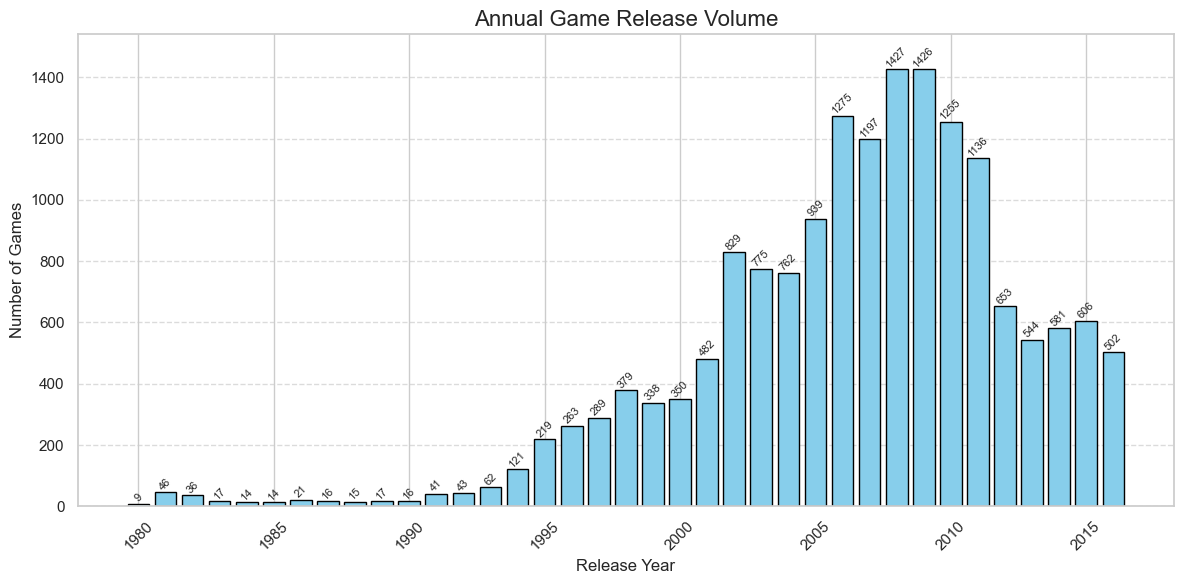

In [73]:

# Create a bar chart for year_of_release counts
# Count occurrences of each year_of_release value
year_counts = games_df['release_year'].value_counts()

# Sort the counts by year
year_counts = year_counts.sort_index()
plt.figure(figsize=(12, 6))
bars = plt.bar(year_counts.index, year_counts.values, color='skyblue', edgecolor='black')

# Add diagonal text on top of each bar
for bar, count in zip(bars, year_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
             ha='center', va='bottom', rotation=45, fontsize=8)

plt.title('Annual Game Release Volume', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1540)
plt.tight_layout()
plt.show()

The most games were released in 2008 and 2009, respectively. There is a fairly steady increase in game production up until those years, and then it begins to drop off. The reason may be that there was increased competition up until that point, thus there were more games being released, and after 2009 certain gaming systems came to dominate the market. Platforms with poor sales would have ceased production, concentrating game production on fewer systems that produced greater volume, yet fewer games.

##### 3.2 Platform Sales Volume

To decide which platforms to track, let's see the sales of all the platforms in the dataset.

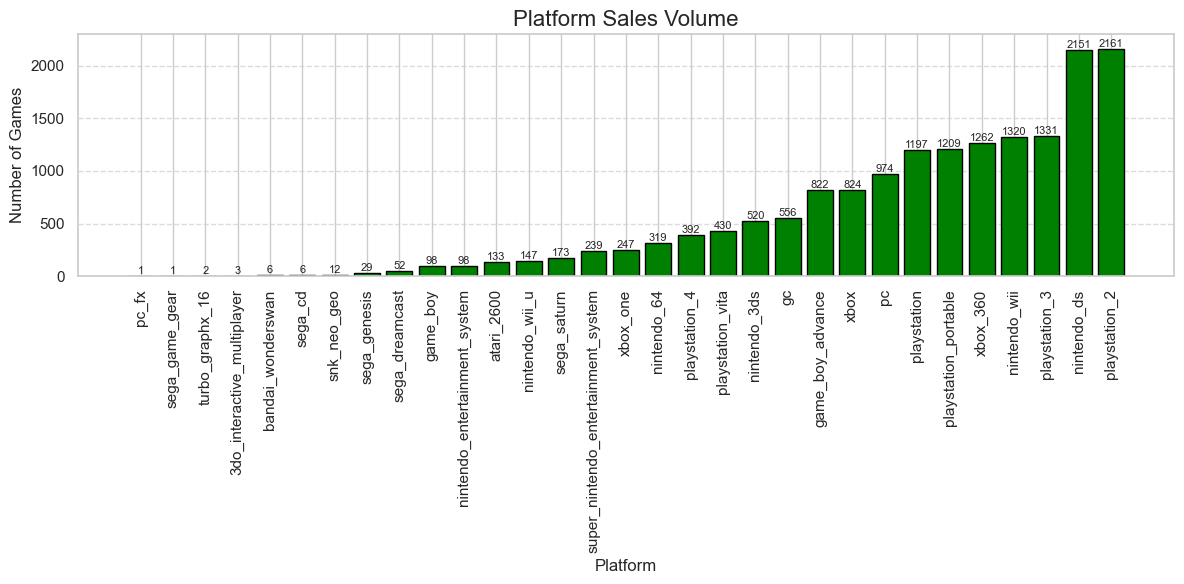

In [74]:

# Create a bar chart for platform counts
platform_volume = games_df['platform'].value_counts(ascending=True)
plt.figure(figsize=(12, 6))
bars = plt.bar(platform_volume.index, platform_volume.values, color='green', edgecolor='black')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90° for a vertical orientation

# Add text on top of each bar
for bar, count in zip(bars, platform_volume.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
             ha='center', va='bottom', fontsize=8)

plt.title('Platform Sales Volume', fontsize=16)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 2300)
plt.tight_layout()
plt.show()

The top five grossing platforms are, from highest to lowest, Playstation 2, Nintendo DS, Playstation 3, Nintendo Wii, and Xbox 360. These five have enough diversity in their sales to show different trends, while simultaneously allowing study of high-grossing platforms. I'll bootstrap these to show sales across the years to be able to predict future sales.

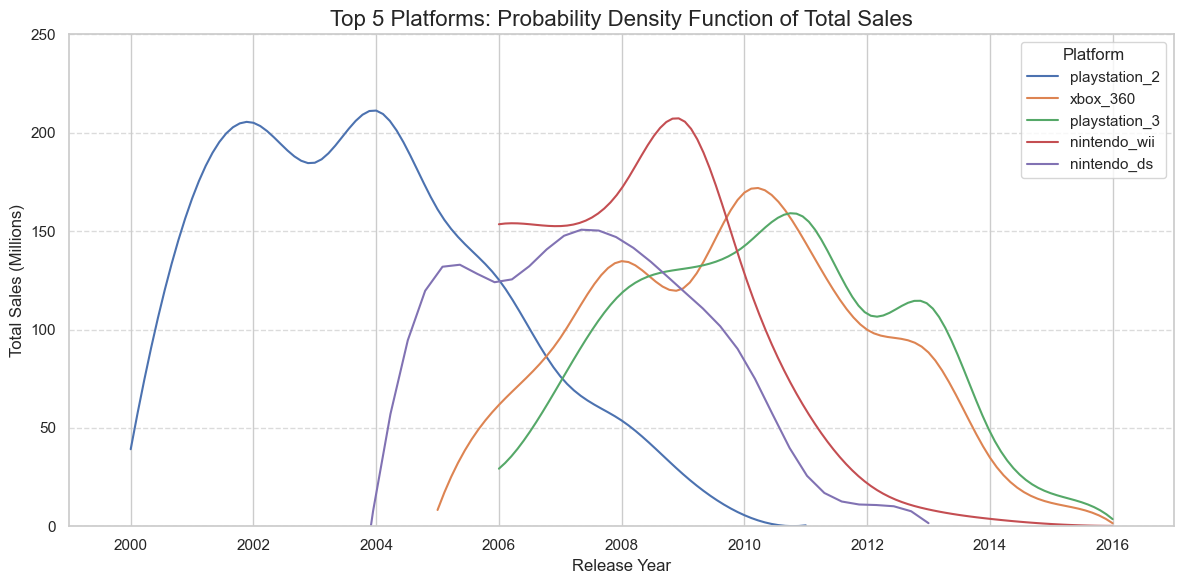

In [75]:
# Define top five platforms
top_5 = games_df.groupby('platform')['total_sales'].sum().nlargest(5).index
# Filter games_df for top_5
top_5_games_df = games_df[games_df['platform'].isin(top_5)]
# Group by 'platform' and 'release_year', summing 'total_sales'
grouped_top_5_yearly_sales = top_5_games_df.groupby(['platform', 'release_year'])['total_sales'].sum().reset_index()
# Build a probability density function (PDF) for each platform in top_5_yearly_sales
def top_5_pdf(data, platform):
    # Filter data for the specific platform
    platform_data = data[data['platform'] == platform]
    # Ensure there are enough data points for spline fitting
    if len(platform_data) < 4:
        return None, None
    # Create a spline for the total sales
    spline = UnivariateSpline(platform_data['release_year'], platform_data['total_sales'], s=1)
    # Generate a range of years for the x-axis
    x = np.linspace(platform_data['release_year'].min(), platform_data['release_year'].max(), 100)
    # Calculate the y-values using the spline
    y = spline(x)
    return x, y

# Create a figure for the PDF plots
plt.figure(figsize=(12, 6))
# Loop through each platform in top_5
for platform in top_5:
    # Build the PDF for the current platform
    x, y = top_5_pdf(grouped_top_5_yearly_sales, platform)
    if x is not None and y is not None:  # Check if the spline was successfully built
        # Plot the PDF
        plt.plot(x, y, label=platform)
# Add labels and title
plt.title('Top 5 Platforms: Probability Density Function of Total Sales', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.xlim(1999, 2017)  # Set x-axis limit to 1999-2017)
plt.ylabel('Total Sales (Millions)', fontsize=12)
plt.ylim(0, 250)  # Set y-axis limit to 0-250
plt.legend(title='Platform')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




The top five grossing platforms began started selling between 2000 and 2006. It appears that by 2016, many were close to zero sales. This begs the question, if these top selling platforms could dip so low in about a decade, what platforms overall had their first year of zero sales in 2016? Since there would be no release_year data for games that did not come out, the best question is: What platforms had their first year of no releases in 2016?

### 3.3 Investigating Release Year Frequency

In [76]:
# Get a list of platforms with releases in 2015
platforms_2015 = games_df[games_df['release_year'] == 2015]['platform'].unique()
# Get a list of platforms with releases in 2016
platforms_2016 = games_df[games_df['release_year'] == 2016]['platform'].unique()
# Find platforms that are in 2015, but not 2016
platforms_2015_not_2016 = [platform for platform in platforms_2015 if platform not in platforms_2016]
# Print platforms that were released in 2015, but not 2016
print("The only platform with release_year data for 2015, but not 2016 was the:")
print()
print(platforms_2015_not_2016)

The only platform with release_year data for 2015, but not 2016 was the:

['playstation_portable']


That's interesting! It looks like the PSP had no releases in 2016. I wonder if that happened before? Let's find the release year, then print all the subsequent unique values for release_year grouped with PSP platform data to see if there are any missing years.

In [77]:
# Find release_year min for playstation_portable
psp_min_year = games_df[games_df['platform'] == 'playstation_portable']['release_year'].min()
print(f"Playstation Portable was released in {psp_min_year}.")
# Group release_year with platform == playstation_portable and print unique values in order
psp_years = sorted(games_df[games_df['platform'] == 'playstation_portable']['release_year'].unique())
print()
print("Playstation Portable release years:")
print()
print(psp_years)

Playstation Portable was released in 2004.

Playstation Portable release years:

[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]


It looks like the PSP had a solid run for nine years in which it released games every year. Let's see how many continuous years of releases all the platforms had.

In [78]:
# Group by 'platform' and get unique release_years
unique_release_years = games_df.groupby('platform')['release_year'].unique()

# Function to format years
def format_years(years):
    years = sorted(years) # Sort the years
    ranges = []
    start = years[0]
    end = years[0]

    for year in years[1:]:
        if year == end + 1: # Check if year is consecutive
            end = year
        else:
           ranges.append(f"{start} to {end}") # Add the range
           start = year # Start a new range
           end = year

    # Add the last range
    ranges.append(f"{start} to {end}")
    return ', '.join(ranges)

# Print the formatted years for each platform
print("Release Years of All Platforms")
print()
for platform, years in unique_release_years.items():
    formatted_years = format_years(years)
    print(f"{platform}: {formatted_years}")
print()

# Count the years each platform had releases
years_count = {platform: len(years) for platform, years in unique_release_years.items()}
# Since 'pc' is an outlier, with 26 years of releases (outside the IQR), we will exclude it from the median calculation
filtered_counts = [count for platform, count in years_count.items() if platform != 'pc']
# Calculate and print the median
median_years = np.median(filtered_counts)
print(f"Median number of release years per platform (excluding PC): {median_years}")

Release Years of All Platforms

3do_interactive_multiplayer: 1994 to 1995
atari_2600: 1980 to 1989, 2006 to 2006
bandai_wonderswan: 1999 to 2001
game_boy: 1988 to 1992, 1994 to 2001, 2006 to 2006
game_boy_advance: 2000 to 2007
gc: 2001 to 2007
nintendo_3ds: 2006 to 2006, 2011 to 2016
nintendo_64: 1996 to 2002, 2006 to 2006
nintendo_ds: 1985 to 1985, 2004 to 2013
nintendo_entertainment_system: 1983 to 1994
nintendo_wii: 2006 to 2016
nintendo_wii_u: 2012 to 2016
pc: 1985 to 1985, 1988 to 1988, 1992 to 1992, 1994 to 2016
pc_fx: 1996 to 1996
playstation: 1994 to 2003, 2006 to 2006
playstation_2: 2000 to 2011
playstation_3: 2006 to 2016
playstation_4: 2013 to 2016
playstation_portable: 2004 to 2015
playstation_vita: 2006 to 2006, 2011 to 2016
sega_cd: 1993 to 1994
sega_dreamcast: 1998 to 2002, 2007 to 2008
sega_game_gear: 1992 to 1992
sega_genesis: 1990 to 1994
sega_saturn: 1994 to 1999
snk_neo_geo: 1993 to 1996
super_nintendo_entertainment_system: 1990 to 1999
turbo_graphx_16: 1995 to 1995

It is not uncommon for platforms to skip years of production for their games. PCs, however, are not simply for gaming, and therefore have the ability to produce games more than other platforms. Therefore, when determining how long it usually takes a platform's sales to get to zero (the platform stops releasing games), with the acknowledgment that sometimes platforms skip years, the median value is seven, which is the value that should be used when estimating the typical platform lifespan. However, this can differ in exceptional cases, like with PCs.

Based upon this information, it is possible to build a sales prognosis for the year 2017. I will use data from 2010-2016, since that is the typical platform lifespan. I will use a univariate spline to allow for smooth prognosis of 2017 sales.

### 4. Game Sale Investigation

##### 4.1 Game Sale Prognosis

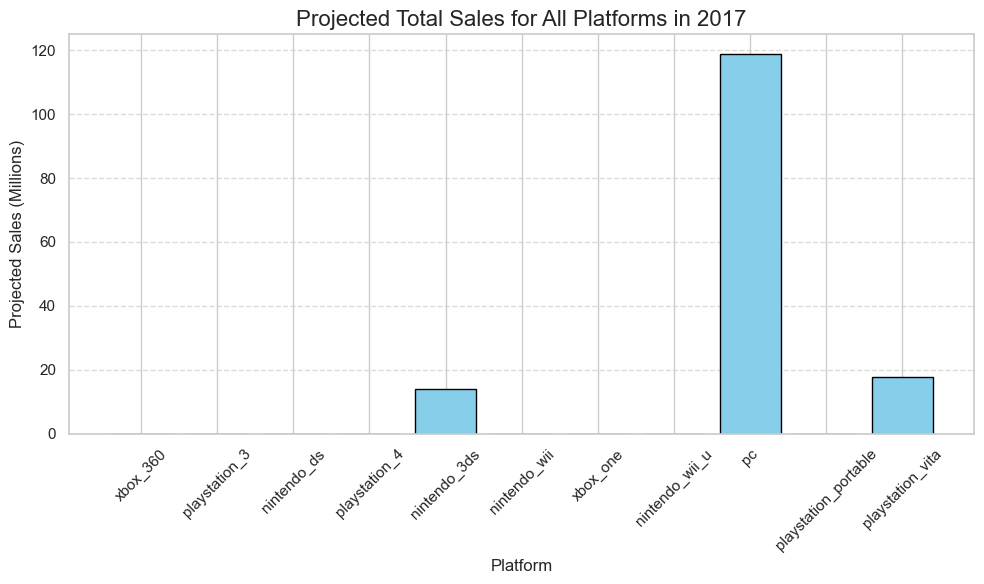

In [79]:
# Filter games_df for years 2010 to 2016
prognosis_data = games_df[(games_df['release_year'] >= 2010) & (games_df['release_year'] <= 2016)]

# Group by 'platform' and 'release_year', summing 'total_sales'
grouped_yearly_sales = prognosis_data.groupby(['platform', 'release_year'])['total_sales'].sum().reset_index()

# Build a probability density function (PDF) for each platform in grouped_yearly_sales
def prog_pdf(data, platform):
    # Filter data for the specific platform
    platform_data = data[data['platform'] == platform]
    # Ensure there are enough data points for spline fitting
    if len(platform_data) < 4:
        return None
    # Create a spline for the total sales
    spline = UnivariateSpline(platform_data['release_year'], platform_data['total_sales'], s=1)
    # Project sales for the year 2017
    projected_sales_2017 = spline(2017)
    return projected_sales_2017

# Create a dictionary to hold projected sales for 2017 for all platforms
projected_sales_2017 = {}

# Get unique platforms from the filtered data
platforms = prognosis_data['platform'].unique()

# Loop through each platform and calculate projected sales for 2017
for platform in platforms:
    projected_sales = prog_pdf(grouped_yearly_sales, platform)
    if projected_sales is not None:
        projected_sales_2017[platform] = projected_sales

# Convert the projected sales dictionary to a DataFrame for plotting
projected_sales_df = pd.DataFrame(list(projected_sales_2017.items()), columns=['platform', 'projected_sales_2017'])

# Create a bar graph for the projected sales in 2017
plt.figure(figsize=(10, 6))
plt.bar(projected_sales_df['platform'], projected_sales_df['projected_sales_2017'], color='skyblue', edgecolor='black')
plt.title('Projected Total Sales for All Platforms in 2017', fontsize=16)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Projected Sales (Millions)', fontsize=12)
plt.ylim(0, 125)  # Set y-axis limit to 0-125
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


It appears that the majority of platorms that released games in 2016 will stop producing games in 2017, with only PC, Nintendo 3DS, and Playstation Vita likely to make money. 

##### 4.2 Box Plot for Global Game Sales

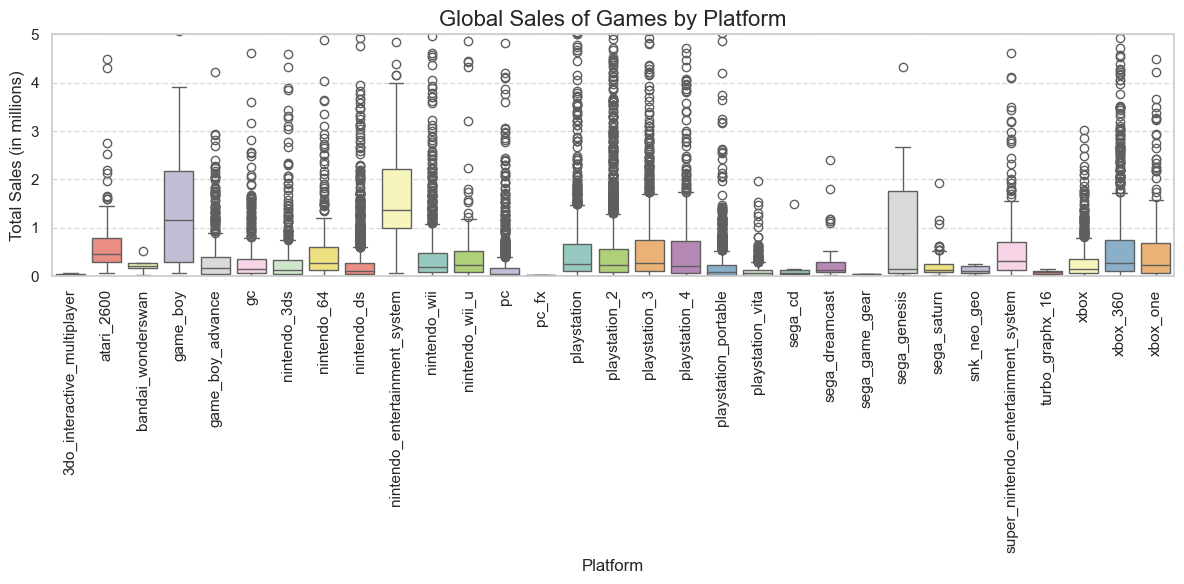

In [80]:
# Sort the platforms alphabetically for the x-axis
sorted_platforms = sorted(games_df['platform'].unique())
plt.figure(figsize=(12, 6))
sns.boxplot(data=games_df, x='platform', y='total_sales', hue='platform', order=sorted_platforms, palette='Set3')

# Customize the plot
plt.title('Global Sales of Games by Platform', fontsize=16)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Total Sales (in millions)', fontsize=12)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.ylim(0, 5)  # Set y-axis limit to focus on the majority of data points
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Based upon the box plots, there are significant differences between platforms. The platforms that stand out due to their larger interquartile ranges and higher medians are the Xbox 360, Nintendo DS, PS2, and Wii. This indicates that they have higher sales per game. On the flipside, SNK Neo Geo, 3DO, PC-FX, and Sega CD show minimal box heights that show their games sold less with less variation. Game Boy and Genesis have wide spread, likely meaning there is a lot of variation in how well their games sold.

##### 4.3 Critic Score and User Score vs. Total Sales Correlation for Playstation 2

Since the PS2 had the highest number of sales, let's take a look at the correlation between user scores and critic scores in relation to total sales.

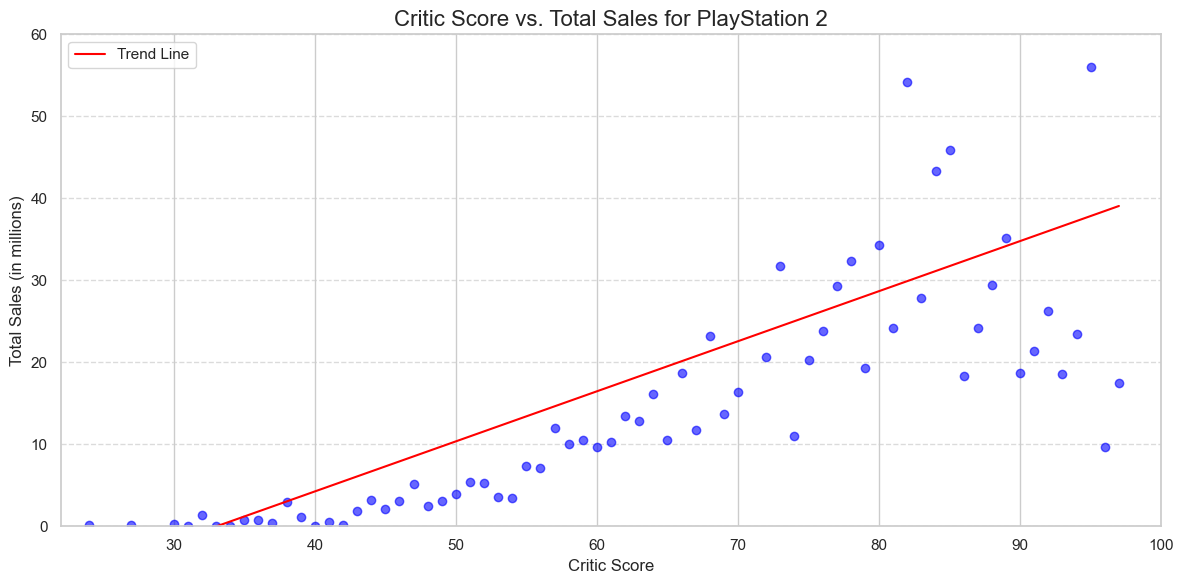


Correlation (per-game) between Critic Score and Total Sales for PS2: 0.35


In [81]:
# Group games_df by playstation_2 and critic_score
ps2_critic_score = games_df[games_df['platform'] == 'playstation_2'].groupby('critic_score')['total_sales'].sum().reset_index()
# Sort the DataFrame by critic_score
ps2_critic_score = ps2_critic_score.sort_values(by='critic_score')

# Create a scatter plot comparing critic_score and total_sales
plt.figure(figsize=(12, 6))
plt.scatter(ps2_critic_score['critic_score'], ps2_critic_score['total_sales'], color='blue', alpha=0.6)
# Add a trend line using statsmodels
X = sm.add_constant(ps2_critic_score['critic_score'])
model = sm.OLS(ps2_critic_score['total_sales'], X).fit()
plt.plot(ps2_critic_score['critic_score'], model.predict(X), color='red', label='Trend Line')
# Customize the plot
plt.title('Critic Score vs. Total Sales for PlayStation 2', fontsize=16)
plt.xlabel('Critic Score', fontsize=12)
plt.ylabel('Total Sales (in millions)', fontsize=12)
plt.xlim(22, 100)  # Set x-axis limit to 22-100
plt.ylim(0, 60)  # Set y-axis limit to 0-200
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()
print()

# Calculate the correlation between critic_score and total_sales, emphasizing per-game granularity
ps2_games_critic_score = games_df[(games_df['platform'] == 'playstation_2') & (games_df['critic_score'])]
ps2_critic_score_correlation = ps2_games_critic_score['critic_score'].corr(ps2_games_critic_score['total_sales'])
print(f'Correlation (per-game) between Critic Score and Total Sales for PS2: {ps2_critic_score_correlation:.2f}')

There is moderate correlation between critic score, and sales. However, since it is not incredibly strong, is is likely other factors like marketing, release timing, fan loyalty, etc. play a large part. Let's take a look at the correlation between user score and sales for comparison.

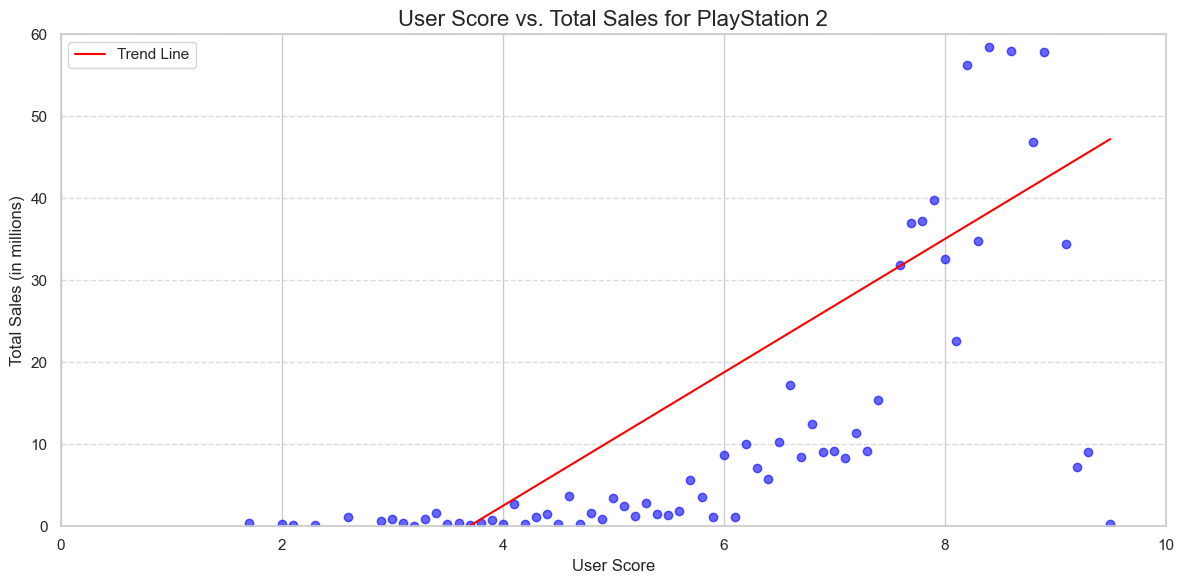

Correlation (per-game) between User Score and Total Sales for PS2: 0.17


In [82]:
# Group games_df by playstation_2 and user_score
ps2_user_score = games_df[games_df['platform'] == 'playstation_2'].groupby('user_score')['total_sales'].sum().reset_index()

# Sort the DataFrame by user_score
ps2_user_score = ps2_user_score.sort_values(by='user_score')

# Create a scatter plot comparing user_score and total_sales
plt.figure(figsize=(12, 6))
plt.scatter(ps2_user_score['user_score'], ps2_user_score['total_sales'], color='blue', alpha=0.6)

# Add a trend line using statsmodels
X = sm.add_constant(ps2_user_score['user_score'])
model = sm.OLS(ps2_user_score['total_sales'], X).fit()
plt.plot(ps2_user_score['user_score'], model.predict(X), color='red', label='Trend Line')

# Customize the plot
plt.title('User Score vs. Total Sales for PlayStation 2', fontsize=16)
plt.xlabel('User Score', fontsize=12)
plt.ylabel('Total Sales (in millions)', fontsize=12)
plt.xlim(0, 10)  # Set x-axis limit to 22-100
plt.ylim(0, 60)  # Set y-axis limit to 0-60
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Calculate the correlation between user_score and total_sales, emphasizing per-game granularity
ps2_games_user_score = games_df[(games_df['platform'] == 'playstation_2') & (games_df['user_score'].notna())]
ps2_user_score_correlation = ps2_games_user_score['user_score'].corr(ps2_games_user_score['total_sales'])
print(f'Correlation (per-game) between User Score and Total Sales for PS2: {ps2_user_score_correlation:.2f}')


There is a week correlation between user score and sales. While there is a small indication that sales in crease as user scores go up, it is not heavy enough to suggest this is the only factor. For instance, there is a data point that has a user score of nearly ten, but it likely has about 0 in sales.

##### 4.4 Critic Score vs. Total Sales Correlation for Common Games Between Playstation 2 and Nintendo DS

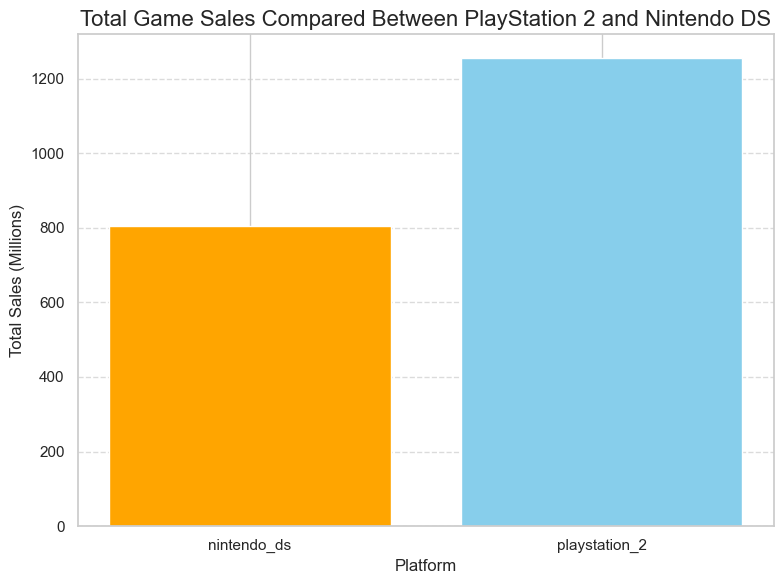

In [83]:
# Filter the DataFrame for games on both PlayStation 2 and Nintendo DS
common_platforms_df = games_df[games_df['platform'].isin(['playstation_2', 'nintendo_ds'])]

# Group platforms by total_sales
grouped_common_sales = common_platforms_df.groupby('platform')['total_sales'].sum().reset_index()

# Plot a bar chart (not a histogram!)
plt.figure(figsize=(8, 6))
platforms = grouped_common_sales['platform']
sales = grouped_common_sales['total_sales']

plt.bar(platforms, sales, color=['orange', 'skyblue'])
plt.title('Total Game Sales Compared Between PlayStation 2 and Nintendo DS', fontsize=16)
plt.ylabel('Total Sales (Millions)', fontsize=12)
plt.xlabel('Platform', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



It could be seen that, individually from the box plots, PS2 games were selling more than Nintendo DS games. It looks like even for the same games being sold, Nintendo DS made less money than Playstation 2. Let's calculate the correlation between user score, critic score, and sales for Nintendo DS.

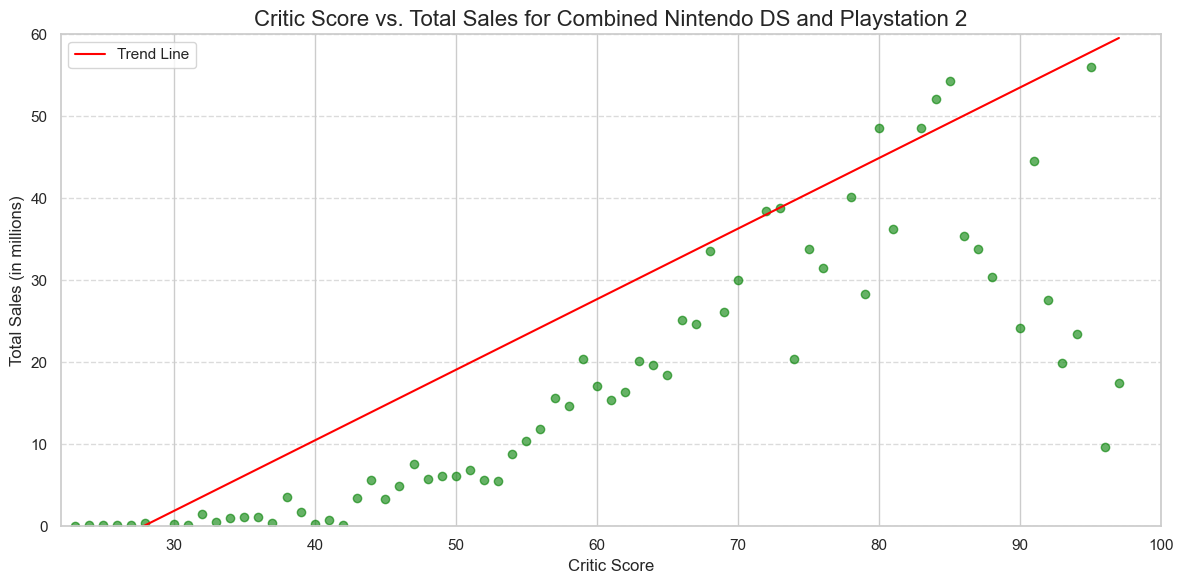


Correlation (per-game) between Critic Score and Total Sales for Nintendo DS: 0.12


NameError: name 'ps2_games' is not defined

In [84]:
# Group games_df by nintendo_ds, playstation_2 and critic_score
nds_ps2_critic_score = games_df[games_df['platform'].isin(['nintendo_ds', 'playstation_2'])].groupby('critic_score')['total_sales'].sum().reset_index()
# Sort the DataFrame by critic_score
nds_ps2_critic_score = nds_ps2_critic_score.sort_values(by='critic_score')

# Create a scatter plot comparing critic_score and total_sales
plt.figure(figsize=(12, 6))
plt.scatter(nds_ps2_critic_score['critic_score'], nds_ps2_critic_score['total_sales'], color='green', alpha=0.6)

# Add a trend line using statsmodels
X = sm.add_constant(nds_ps2_critic_score['critic_score'])
model = sm.OLS(nds_ps2_critic_score['total_sales'], X).fit()
plt.plot(nds_ps2_critic_score['critic_score'], model.predict(X), color='red', label='Trend Line')

# Customize the plot
plt.title('Critic Score vs. Total Sales for Combined Nintendo DS and Playstation 2', fontsize=16)
plt.xlabel('Critic Score', fontsize=12)
plt.ylabel('Total Sales (in millions)', fontsize=12)
plt.xlim(22, 100)
plt.ylim(0, 60)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
print()

# Calculate the correlation between critic_score and total_sales (per-game) for NDS
nds_games_critic_score = games_df[(games_df['platform'] == 'nintendo_ds') & (games_df['critic_score'].notnull())]
nds_critic_score_correlation = nds_games_critic_score['critic_score'].corr(nds_games_critic_score['total_sales'])
print(f'Correlation (per-game) between Critic Score and Total Sales for Nintendo DS: {nds_critic_score_correlation:.2f}')
# Restate PS2 critic score correlation for reference
ps2_games_critic_score = games_df[(games_df['platform'] == 'playstation_2') & (games_df['critic_score'])]
ps2_critic_score_correlation = ps2_games['critic_score'].corr(ps2_games['total_sales'])
print(f'Correlation (per-game) between Critic Score and Total Sales for PS2: {ps2_critic_score_correlation:.2f}')
# Calculate combined correlation between critic_score and total_sales for Nintendo DS and PlayStation 2
# Filter the DataFrame for games on both PlayStation 2 and Nintendo DS
nds_ps2_critic_score = games_df[games_df['platform'].isin(['nintendo_ds', 'playstation_2']) & (games_df['critic_score'].notnull())]
nds_ps2_critic_score_correlation = nds_ps2_critic_score['critic_score'].corr(nds_ps2_critic_score['total_sales'])
print(f'Correlation (per-game) between Critic Score and Total Sales for combined Nintendo DS and Playstation 2: {nds_ps2_critic_score_correlation:.2f}')

For Nintendo DS alone, there is a weak correlation between critic score and sales. Therefore, it appears that Nintendo DS games may have much more of a cult following that is not dependent upon critic score, and that DS users may be more susceptible to branding, marketing, etc. PS2 correlation is slightly higher for critic score, indicating those customers place just a bit more stock in critic score. While there is a suggestion that comparatively, critic score has some bearing on game sales for both platforms, there are other salient factors for sales that must be taken into consideration. When combined, the total sales for both indicate a stronger, yet still weak, correlation. Therefore, if there is some type of combo deal on DS games with poor critic score, and PS2 games with better user score, it could be advantageous for DS.

Let's look at the combined user score scatter plot and relevant correlations for DS and PS2, as well.

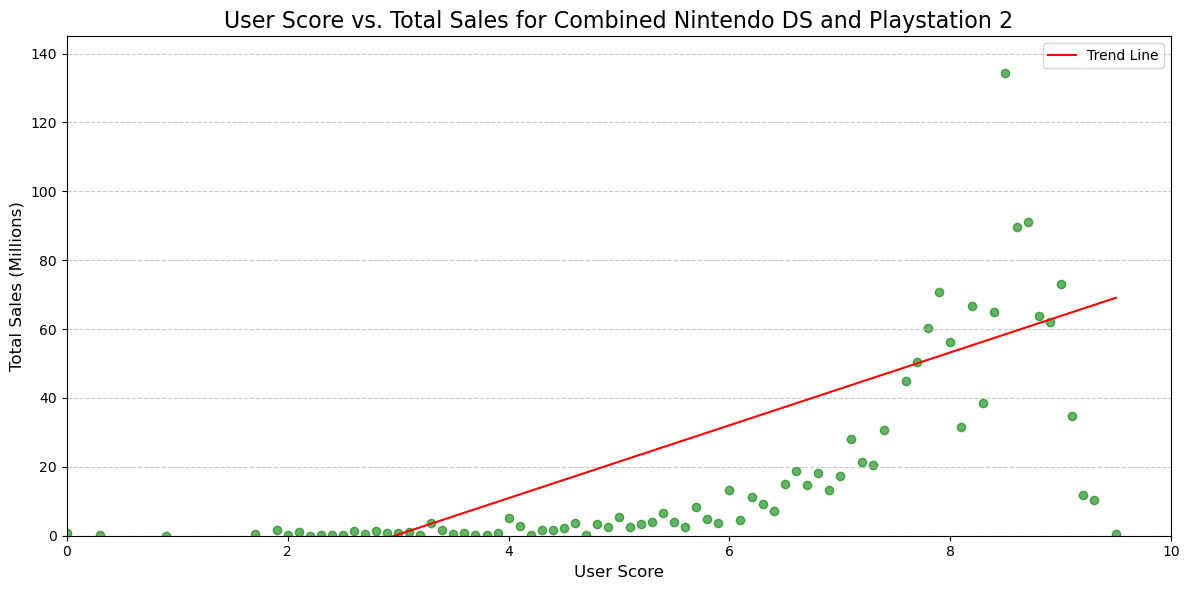


Correlation (per-game) between User Score and Total Sales for Nintendo DS: 0.05
Correlation (per-game) between User Score and Total Sales for PS2: 0.17
Correlation (per-game) between User Score and Total Sales for combined Nintendo DS and Playstation 2: 0.12


In [ ]:
# Group games_df by playstation_2, nintendo_ds and user_score
nds_ps2_user_score = games_df[games_df['platform'].isin(['nintendo_ds', 'playstation_2'])].groupby('user_score')['total_sales'].sum().reset_index()
# Sort the DataFrame by user_score
nds_ps2_user_score = nds_ps2_user_score.sort_values(by='user_score')

# Create a scatter plot comparing critic_score and total_sales
plt.figure(figsize=(12, 6))
plt.scatter(nds_ps2_user_score['user_score'], nds_ps2_user_score['total_sales'], color='green', alpha=0.6)

# Add a trend line using statsmodels
X = sm.add_constant(nds_ps2_user_score['user_score'])
model = sm.OLS(nds_ps2_user_score['total_sales'], X).fit()
plt.plot(nds_ps2_user_score['user_score'], model.predict(X), color='red', label='Trend Line')

# Customize the plot
plt.title('User Score vs. Total Sales for Combined Nintendo DS and Playstation 2', fontsize=16)
plt.xlabel('User Score', fontsize=12)
plt.ylabel('Total Sales (Millions)', fontsize=12)
plt.xlim(0, 10)
plt.ylim(0, 145)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
print()

# Calculate the correlation between user_score and total_sales (per-game) for NDS
nds_games = games_df[(games_df['platform'] == 'nintendo_ds') & (games_df['user_score'].notnull())]
nds_correlation = nds_games['user_score'].corr(nds_games['total_sales'])
print(f'Correlation (per-game) between User Score and Total Sales for Nintendo DS: {nds_correlation:.2f}')
# Restate PS2 critic score correlation for reference
ps2_games_user_score = games_df[(games_df['platform'] == 'playstation_2') & (games_df['user_score'])]
correlation = ps2_games_user_score['user_score'].corr(ps2_games['total_sales'])
print(f'Correlation (per-game) between User Score and Total Sales for PS2: {correlation:.2f}')
# Calculate combined correlation between user_score and total_sales for Nintendo DS and PlayStation 2
# Filter the DataFrame for games on both PlayStation 2 and Nintendo DS
nds_ps2_user_score = games_df[games_df['platform'].isin(['nintendo_ds', 'playstation_2']) & (games_df['user_score'].notnull())]
nds_ps2_user_score_correlation = nds_ps2_user_score['user_score'].corr(nds_ps2_user_score['total_sales'])
print(f'Correlation (per-game) between User Score and Total Sales for combined Nintendo DS and Playstation 2: {nds_ps2_user_score_correlation:.2f}')

While, inevitably, there is some correlation between user score and sales, it does not appear extremely relevant. It appears that DS users will purchase regardless of others' opinions, perhaps indicating a more individualistic user type than for Playstation 2. DS users are likely hobbyists rather than what is termed "serious gamers" within that community, pursuing DS gaming for pleasure more than clout, popularity, or reputation.

### 5. Sales by Genre



##### 5.1 Total Sales

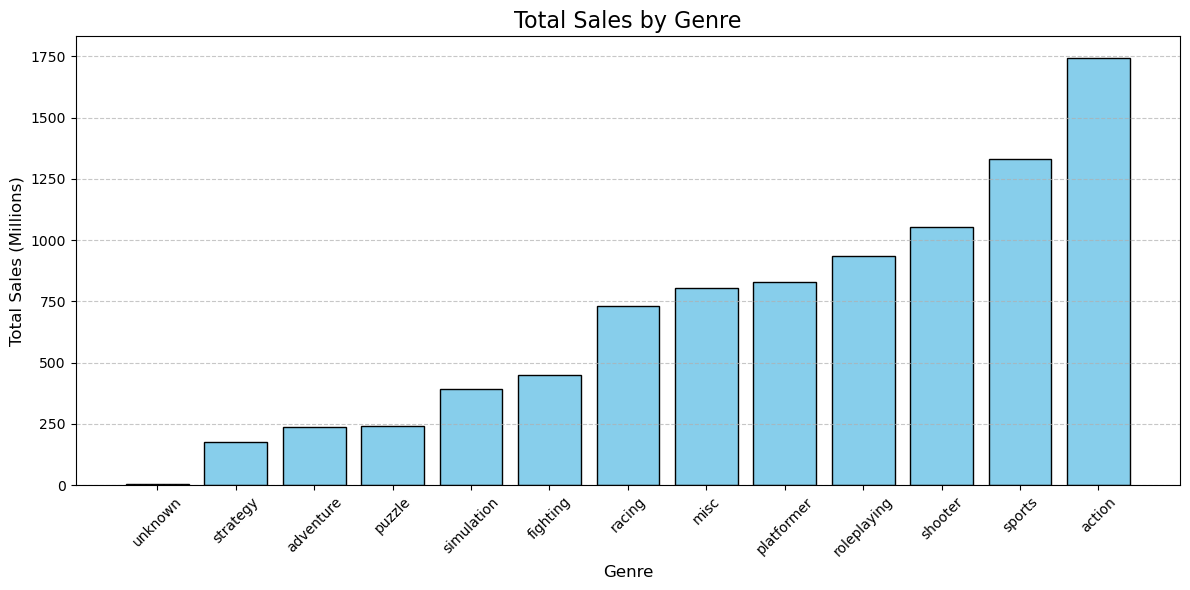

In [ ]:
# Make bar chart of total_sales by genre
plt.figure(figsize=(12, 6))
# Group by genre and sum total_sales
genre_sales = games_df.groupby('genre')['total_sales'].sum().reset_index()
# Sort the DataFrame by total_sales
genre_sales = genre_sales.sort_values(by='total_sales')
# Create a bar plot
plt.bar(genre_sales['genre'], genre_sales['total_sales'], color='skyblue', edgecolor='black')
# Add labels and title
plt.title('Total Sales by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Total Sales (Millions)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Worldwide, it looks like action games are, by far, the most profitable of all video games, followed by sports and shooter, roleplaying, etc. Let's take a look at the curve of the sales throughout the years.

##### 5.2 Probability Density Function of Total Sales

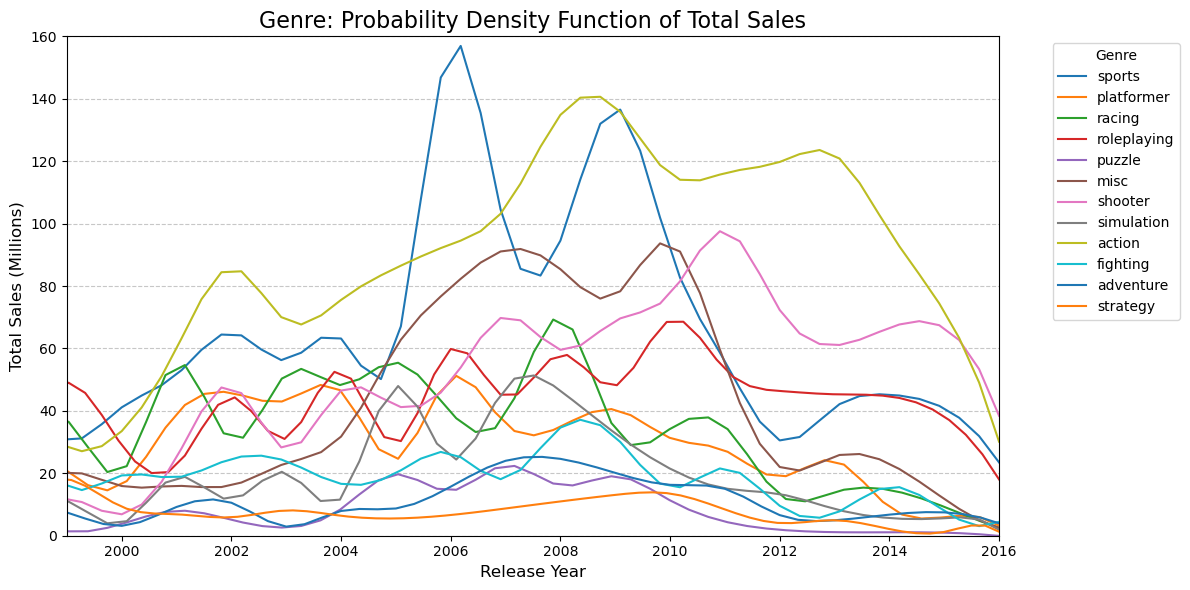

In [ ]:
# Create a PDF for all genres with total_sales as y-axis and release_year as x-axis
def genre_pdf(data, genre):
    # Filter data for the specific genre
    genre_data = data[data['genre'] == genre]

    # Aggregate total sales by release year
    yearly_sales = genre_data.groupby('release_year')['total_sales'].sum().reset_index()

    # Ensure there are enough data points for spline fitting
    if len(yearly_sales) < 4:
        return None, None

    # Sort by release year
    yearly_sales = yearly_sales.sort_values('release_year')

    # Create a spline for the total sales
    spline = UnivariateSpline(yearly_sales['release_year'], yearly_sales['total_sales'], s=10)
   
    # Generate a range of years for the x-axis
    x = np.linspace(yearly_sales['release_year'].min(), yearly_sales['release_year'].max(), 100)

    # Calculate the y-values using the spline
    y = spline(x)
    return x, y

# Create a figure for the PDF plots
plt.figure(figsize=(12, 6))

# Loop through each genre
for genre in games_df['genre'].dropna().unique():
    # Build the PDF for the current genre
    x, y = genre_pdf(games_df, genre)
    if x is not None and y is not None:  # Check if the spline was successfully built
        # Plot the PDF
        plt.plot(x, y, label=genre)

# Add labels and title
plt.title('Genre: Probability Density Function of Total Sales', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.xlim(1999, 2016)
plt.ylabel('Total Sales (Millions)', fontsize=12)
plt.ylim(0, 160)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Though sports spiked to about 160 million dollars in sales in 2006, that quickly dropped off by about 2007 as action games continued to rise, peaking in early 2008 before sharing some overlap with sports sales, which again dropped off fairly precipitously. It is likely that there are certain events that happen around the sports sales spikes that cause their purchase to go up, e.g. the world cup, etc. Though shooter games started off with fairly low sales, it appears that as of 2016 they were still selling more than both sports and action games. As of 2016, the top grossing genres were, in order of sales:

1) Shooter
2) Action
3) Sports

   and

4) Roleplaying

#### 5. Regional Profiles

##### 5.1 Global Platform Performance

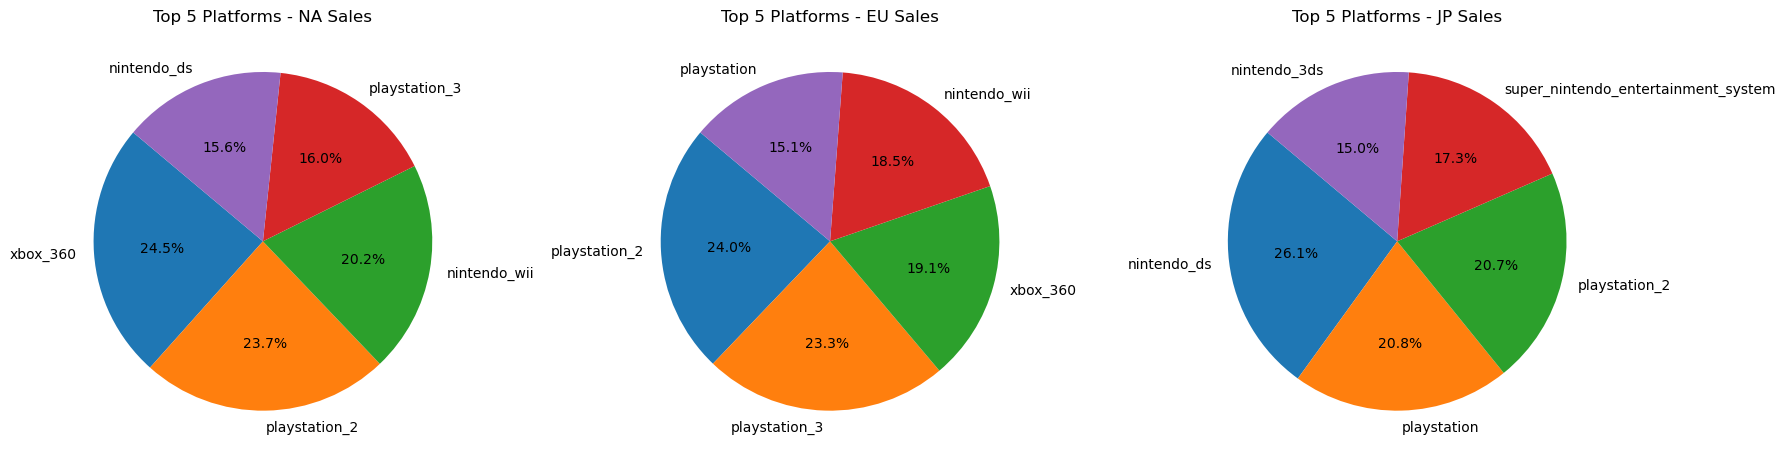

Top 5 Platforms in North America:
platform
xbox_360         602.47
playstation_2    583.84
nintendo_wii     496.90
playstation_3    393.49
nintendo_ds      382.40
Name: na_sales, dtype: float64

Top 5 Platforms in Europe:
platform
playstation_2    339.29
playstation_3    330.29
xbox_360         270.76
nintendo_wii     262.21
playstation      213.61
Name: eu_sales, dtype: float64

Top 5 Platforms in Japan:
platform
nintendo_ds                            175.57
playstation                            139.82
playstation_2                          139.20
super_nintendo_entertainment_system    116.55
nintendo_3ds                           100.67
Name: jp_sales, dtype: float64


In [ ]:
# Get top 5 platforms in each region
top_na_platforms = games_df.groupby('platform')['na_sales'].sum().nlargest(5)
top_eu_platforms = games_df.groupby('platform')['eu_sales'].sum().nlargest(5)
top_jp_platforms = games_df.groupby('platform')['jp_sales'].sum().nlargest(5)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# NA Pie Chart
axs[0].pie(top_na_platforms.values, labels=top_na_platforms.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Top 5 Platforms - NA Sales')

# EU Pie Chart
axs[1].pie(top_eu_platforms.values, labels=top_eu_platforms.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Top 5 Platforms - EU Sales')

# JP Pie Chart
axs[2].pie(top_jp_platforms.values, labels=top_jp_platforms.index, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Top 5 Platforms - JP Sales')

plt.tight_layout()
plt.show()

# Print the top 5 platforms in each region
print("Top 5 Platforms in North America:")
print(top_na_platforms)
print()
print("Top 5 Platforms in Europe:")
print(top_eu_platforms)
print()
print("Top 5 Platforms in Japan:")
print(top_jp_platforms)

The pie charts above show the market performance of the five top platforms in all three regions. 

The North American market favors home consoles, with Xbox 360 and Nintendo Wii in the lead, signaling popularity of motion-controlled and online multiplayer gaming. Nintendo DS suggests the proclivity for portable gameplay, as well. Sony is popular due to Playstation 3 popularity, but Microsoft and Nintendo lead the pack.

Europe's sales are more equally distributed than those of North America. However, PlayStation systems and Xbox 360 have the most sales, again signaling competition between the big three of Microsoft, Sony, and Nintendo. Europe has a higher proclivity for handheld gaming, since both Nintendo DS and PSP make the top five.

Japan, like Europe, is more evenly distributed than North America. Some of the usual culprits are present, with Nintendo DS holding the distinction as top grossing platform, and the Nintendo 3DS holding its own as the lowest grossing of the top five. PlayStation and PlayStation 2 hold second and third place in the top five. The most surprising thing about Japan's market is that SNES made the top five at all, showing a particular appreciation and loyalty to the nostalgia of vintage Nintendo platforms. In addition, Xbox 360, which made the top five in both Europe and North America, is nowhere to be found in Japan's top five! This is, perhaps, the most interesting market in terms of bucking the triends of Western markets. 

Let's continue by investigating the top five genres between the three regions.



##### 5.2 Global Genre Performance

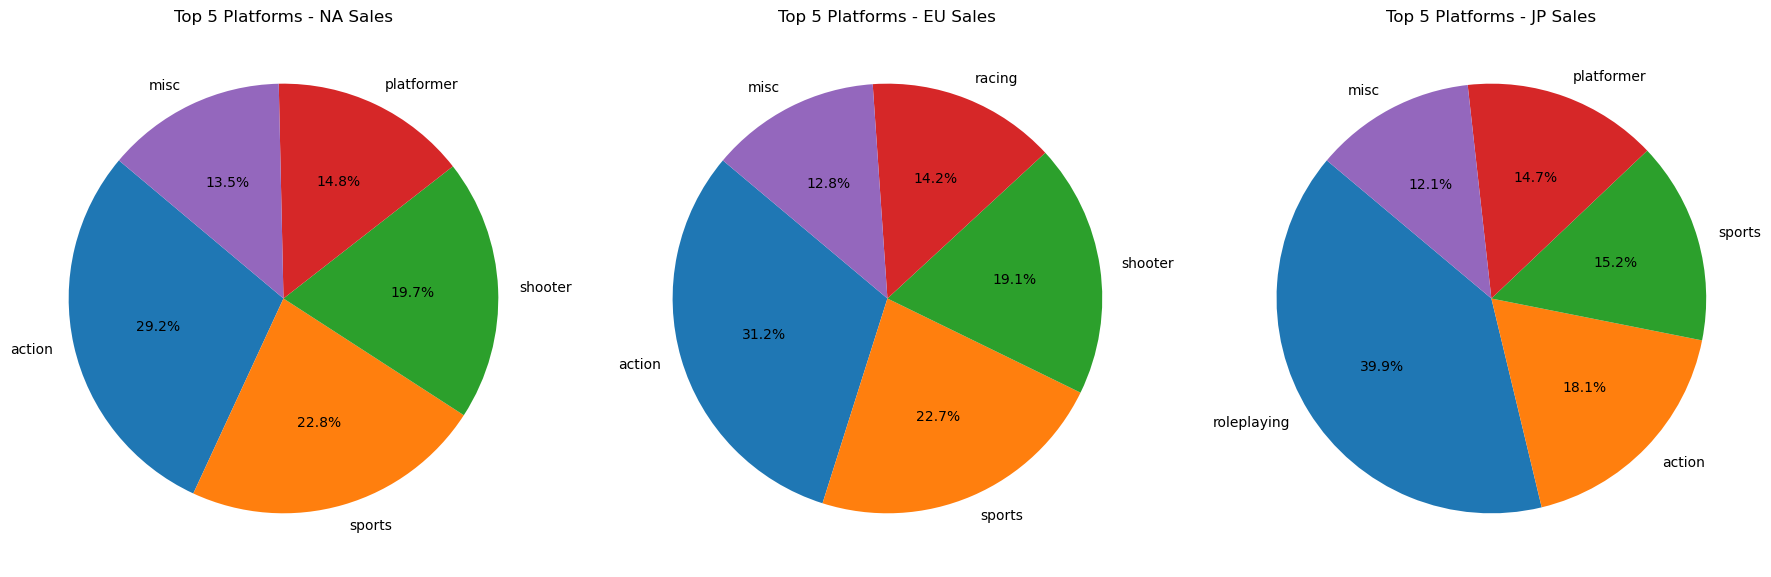

Top 5 Genres in North America:
genre
action        879.01
sports        684.43
shooter       592.24
platformer    445.50
misc          407.27
Name: na_sales, dtype: float64

Top 5 Genres in Europe:
genre
action     519.13
sports     376.79
shooter    317.34
racing     236.51
misc       212.74
Name: eu_sales, dtype: float64

Top 5 Gemres in Japan:
genre
roleplaying    355.41
action         161.43
sports         135.54
platformer     130.83
misc           108.11
Name: jp_sales, dtype: float64


In [ ]:
# Get top 5 platforms in each region
top_na_genres = games_df.groupby('genre')['na_sales'].sum().nlargest(5)
top_eu_genres = games_df.groupby('genre')['eu_sales'].sum().nlargest(5)
top_jp_genres = games_df.groupby('genre')['jp_sales'].sum().nlargest(5)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# NA Pie Chart
axs[0].pie(top_na_genres.values, labels=top_na_genres.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Top 5 Platforms - NA Sales')

# EU Pie Chart
axs[1].pie(top_eu_genres.values, labels=top_eu_genres.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Top 5 Platforms - EU Sales')

# JP Pie Chart
axs[2].pie(top_jp_genres.values, labels=top_jp_genres.index, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Top 5 Platforms - JP Sales')

plt.tight_layout()
plt.show()

# Print the top 5 platforms in each region
print("Top 5 Genres in North America:")
print(top_na_genres)
print()
print("Top 5 Genres in Europe:")
print(top_eu_genres)
print()
print("Top 5 Gemres in Japan:")
print(top_jp_genres)

In North America, action, sports, and shooter games dominate the market, in that order, indicating a penchant for high-energy, competitive, and bloody/violent games. Platformers and miscellaneous games show variety, coming in at fourth and fifth in the top five, indicating a noticeable minority of sale geared towards more purely skills-based gaming without the more visceral draw of life or death hypotheticals that the leading three games type have.

Action games have a higher market share in Europe than they do in North America, if only slightly, followed by nearly identical market shares as in North America for sports and shooter games. The prevalence of racing games, which hold the fourth spot in the top five, show a regional preference not found in either Europe or North America, though this still mirrors North America's preference for adrenaline-pumping games quite closely. Miscellaneous games come in last with about a tenth of market share.

Japan has the most distinctive genre market, as evidenced by roleplaying games dominating by a huge nearly 40% of market share, indicating immersive story-driven games with in-depth narratives and strategy are more important in Japan than rapid pacing. Action and sports come in second and third, with platformers in fourth above the universal trend of miscellaneous genres at the bottom of the top five.

The top market shares in each region are action for North America and Europe, followed by roleplaying for Japan.

##### 5.3 Regional Effects of ESRB Ratings

Let's also look at how ESRB ratings affected global sales. Certain values will have to be ignored because they are not real ratings (pre-ESRB or not rated by ESRB) or they represent less than two percent of the market share (KA, AO, etc.).

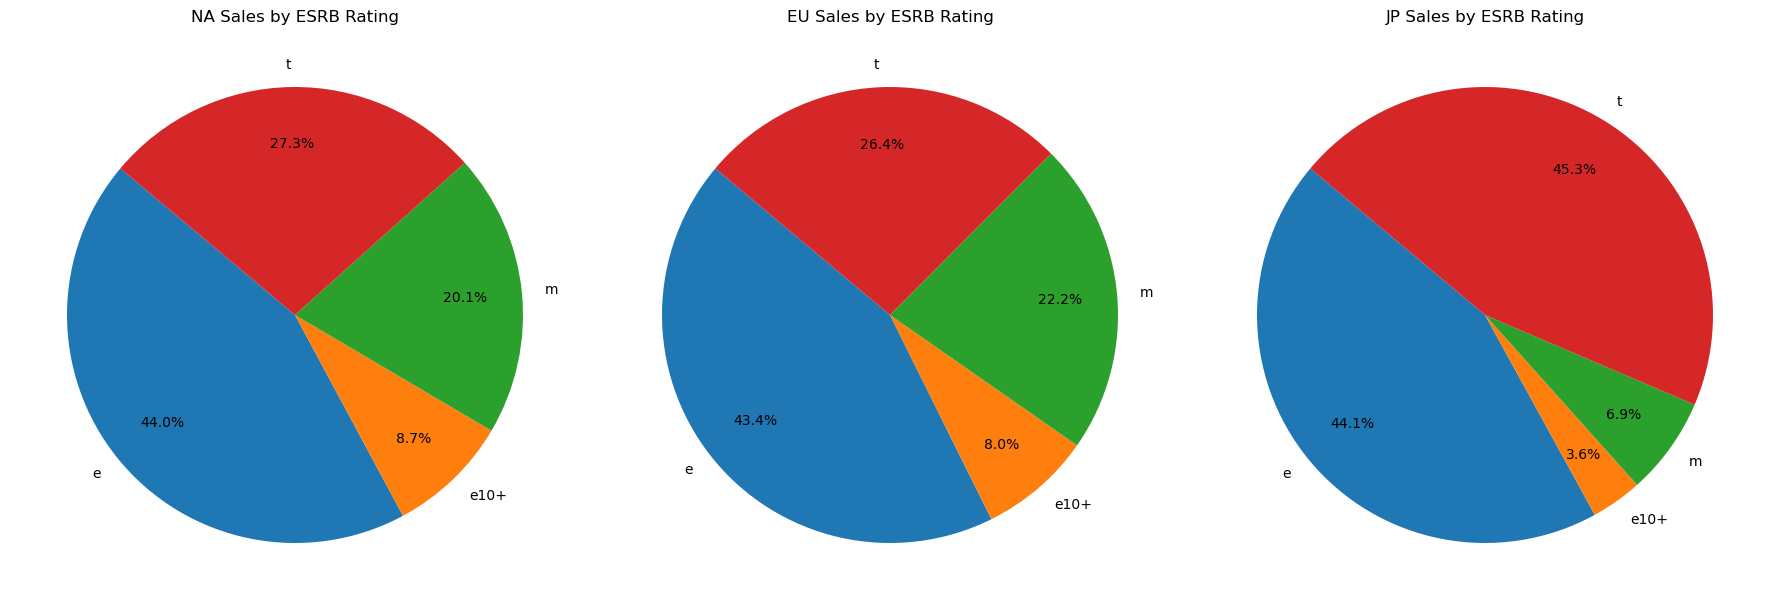

In [ ]:
# Keep only ESRB ratings that are relevant, shunting those that take up less than 2 of market value or that are not ESRB ratings
included_ratings = ['e', 'e10+', 'm', 't']

# Filter charts to only include selected ratings and those with sales > 0
na_esrb = na_esrb[na_esrb.index.isin(included_ratings) & (na_esrb > 0)]
eu_esrb = eu_esrb[eu_esrb.index.isin(included_ratings) & (eu_esrb > 0)]
jp_esrb = jp_esrb[jp_esrb.index.isin(included_ratings) & (jp_esrb > 0)]


# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart configuration
pie_config = {
    "autopct": '%1.1f%%',
    "startangle": 140,
    "labeldistance": 1.1,
    "pctdistance": 0.75
}

# NA Pie Chart (filtered)
axs[0].pie(na_esrb.values, labels=na_esrb.index, **pie_config)
axs[0].set_title('NA Sales by ESRB Rating')

# EU Pie Chart (unchanged)
axs[1].pie(eu_esrb.values, labels=eu_esrb.index, **pie_config)
axs[1].set_title('EU Sales by ESRB Rating')

# JP Pie Chart (unchanged)
axs[2].pie(jp_esrb.values, labels=jp_esrb.index, **pie_config)
axs[2].set_title('JP Sales by ESRB Rating')

plt.tight_layout()
plt.show()

There are some notable similarities and difference among global sales by ESRB rating across Japan, Europe, and North America. Games rated E for Everyone lead sales on all regions. Games rated M for Mature sell better in Western markets, but are a minority of sales in Japan. Games rated T for Teen sell the best in Japan, with European and North American markets trailing behind in that order. Games rated E10+ (Everyone Ten and Up) have about a tenth of the market in both Europe and North America, respectively, but are nearly inconsequential in the Japanese market.

### 6 Testing User Ratings

##### 6.1 User Score T-Test

I will test the user scores of two random platforms to gain quantitative evidence regarding user preferences. In this case, I will test the user scores of the Xbox One and PC. This will help to gain platform-specific feedback that will help determine if users on Xbox One and PC rate games differently, and therefore gain insights into potential platform-specific issues. It will also help to see if devs publishers on each platform should prioritize further development in the way of user experience or optimization. This will help to see where improvements should go, or if equal development for both platforms is justified.

The hypothesis I will be testing is: Average user ratings of the Xbox One and PC platforms are the same. Since this is a basic bifurcated question, the null hypothesis is, "The average user ratings for Xbox One and PC are equal," while the alternative hypothesis is, "The average user ratings for Xbox One and PC are not equal."

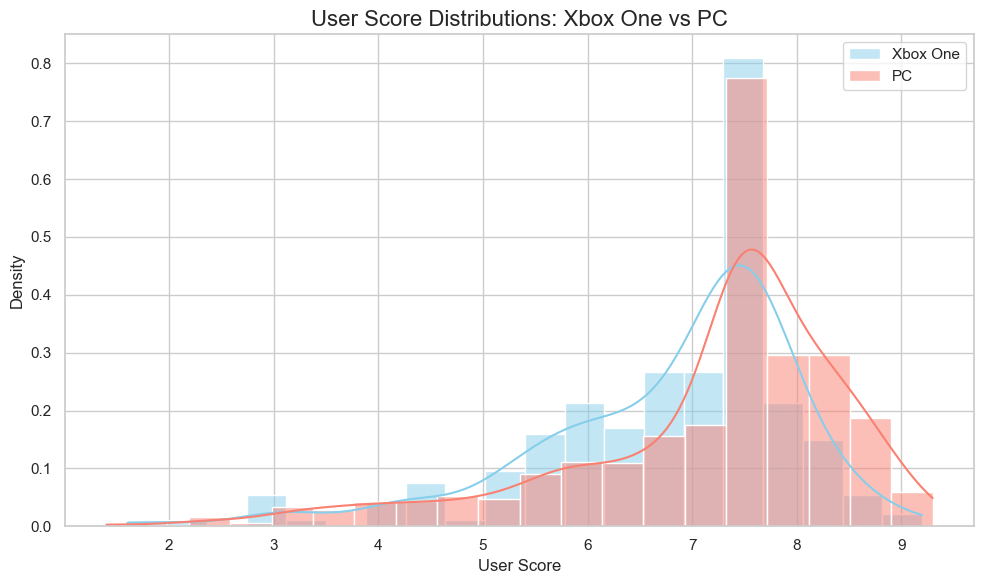

A two-tailed independent t-test revealed that the mean user scores for Xbox One and PC were significantly different, t(df) = -4.10, p = 0.0000

Mean of Xbox One Users Score: 6.778947368421053
Standard Deviation of Xbox One Users Score: 1.2607755490266817

Mean of PC Users Score: 7.154106776180699
Standard Deviation of PC Users Score: 1.371767366204582


In [ ]:
# Filter user_score to exclude missing or invalid entries just in case
user_score_df = games_df.copy()
user_score_df = user_score_df[user_score_df['user_score'].notnull()]
user_score_df['user_score'] = pd.to_numeric(user_score_df['user_score'], errors='coerce')

# Get user scores for Xbox One and PC
xbox_one_user_scores = user_score_df[user_score_df['platform'] == 'xbox_one']['user_score']
pc_user_scores = user_score_df[user_score_df['platform'] == 'pc']['user_score']

# Run independent t-test (Welch’s t-test)
t_stat1, p_value1 = stats.ttest_ind(xbox_one_user_scores, pc_user_scores, equal_var=False)

# Set a clean style
sns.set(style="whitegrid")
xbox_mean = xbox_one_user_scores.mean()
xbox_std = xbox_one_user_scores.std()
pc_mean = pc_user_scores.mean()
pc_std = pc_user_scores.std()

# Plot distributions
plt.figure(figsize=(10, 6))
sns.histplot(xbox_one_user_scores, color='skyblue', kde=True, label='Xbox One', stat="density", bins=20)
sns.histplot(pc_user_scores, color='salmon', kde=True, label='PC', stat="density", bins=20)

# Add titles and labels
plt.title("User Score Distributions: Xbox One vs PC", fontsize=16)
plt.xlabel("User Score", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

print(f"A two-tailed independent t-test revealed that the mean user scores for Xbox One and PC were significantly different, t(df) = {t_stat1:.2f}, p = {p_value1:.4f}")
print()
print(f"Mean of Xbox One Users Score: {xbox_mean}")
print(f"Standard Deviation of Xbox One Users Score: {xbox_std}")
print()
print(f"Mean of PC Users Score: {pc_mean}")
print(f"Standard Deviation of PC Users Score: {pc_std}")

A two-tailed Welch's t-test revealed a statistically significant difference in user scores between Xbox One and PC platforms, and therefore the null hypothesis is rejected. There is strong evidence that average user scores for Xbox One and PC games are not equal. The negative t-statistic indicates that the mean score for Xbox One user scores are lower than for PC. This is suggestive that PC games enjoy significantly higher user ratings than Xbox One games on average, taking into account the assumption of both fair sampling and equal scales. The standard deviation of both sets of data indicate moderative variability, and the t-test confirms a difference in means of appoximatley .38 points.

Let's perform the same operation with the critic score.

##### 6.2 Critic Score T-Test

As the t-test for critic score is also a standard bifurcated question. Therefore, the null hypothesis is, "The average critic ratings for Xbox One and PC are equal," while the alternative hypothesis is, "The average critic ratings for Xbox One and PC are not equal."

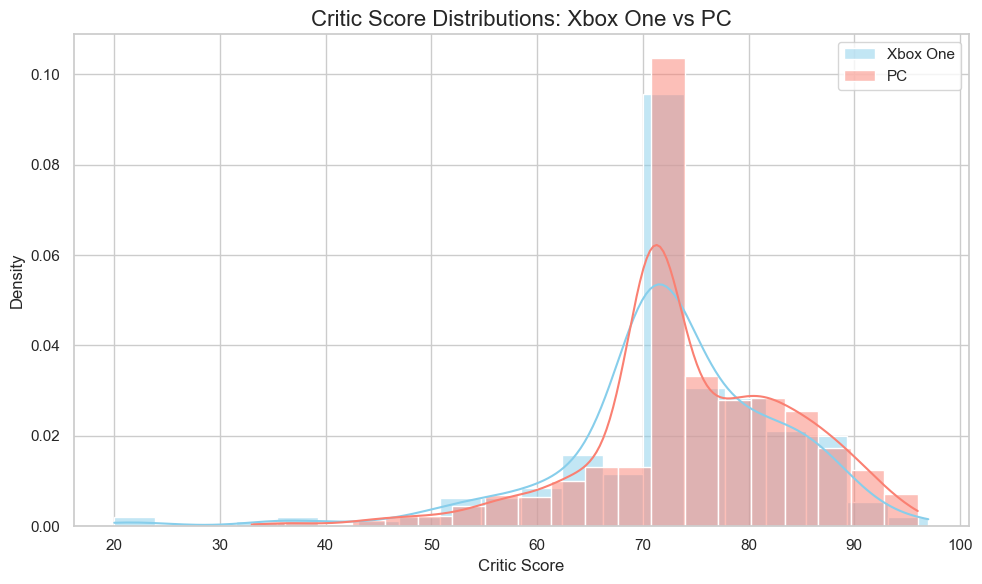

A two-tailed independent t-test revealed that the mean critic scores for Xbox One and PC were significantly different, t(df) = -2.69, p = 0.0075

Mean of Xbox One Users Score: 6.778947368421053
Standard Deviation of Xbox One Users Score: 1.2607755490266817

Mean of PC Users Score: 7.154106776180699
Standard Deviation of PC Users Score: 1.371767366204582


In [ ]:
# Filter critic_score to exclude missing or invalid entries just in case
critic_score_df = games_df.copy()
critic_score_df = critic_score_df[critic_score_df['critic_score'].notnull()]
critic_score_df['critic_score'] = pd.to_numeric(critic_score_df['critic_score'], errors='coerce')

# Get critic scores for Xbox One and PC
xbox_one_critic_scores = critic_score_df[critic_score_df['platform'] == 'xbox_one']['critic_score']
pc_critic_scores = critic_score_df[critic_score_df['platform'] == 'pc']['critic_score']

# Run independent t-test (Welch’s t-test)
t_stat1, p_value1 = stats.ttest_ind(xbox_one_critic_scores, pc_critic_scores, equal_var=False)

# Set a clean style
sns.set(style="whitegrid")
xbox_mean = xbox_one_user_scores.mean()
xbox_std = xbox_one_user_scores.std()
pc_mean = pc_user_scores.mean()
pc_std = pc_user_scores.std()

# Plot distributions
plt.figure(figsize=(10, 6))
sns.histplot(xbox_one_critic_scores, color='skyblue', kde=True, label='Xbox One', stat="density", bins=20)
sns.histplot(pc_critic_scores, color='salmon', kde=True, label='PC', stat="density", bins=20)

# Add titles and labels
plt.title("Critic Score Distributions: Xbox One vs PC", fontsize=16)
plt.xlabel("Critic Score", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

print(f"A two-tailed independent t-test revealed that the mean critic scores for Xbox One and PC were significantly different, t(df) = {t_stat1:.2f}, p = {p_value1:.4f}")
print()
print(f"Mean of Xbox One Users Score: {xbox_mean}")
print(f"Standard Deviation of Xbox One Users Score: {xbox_std}")
print()
print(f"Mean of PC Users Score: {pc_mean}")
print(f"Standard Deviation of PC Users Score: {pc_std}")

In this instance, the t-test results indicate that there is a statistically significant difference in user scores between Xbox One and PC, with a p-value less than 0.05. The mean user score for Xbox One is higher than that for PC, suggesting that Xbox One games are rated more favorably by users compared to PC games. The standard deviations indicate that the variability in user scores is similar for both platforms.

### 7. Conclusion

Analysis of Ice sales uncovered trends that influenced video games success and failure to forecast sales for 2017. After the data was cleaned, prepared, and tested for inconsistent values, I conducted an exploratory analysis by identifying the most popular platforms and genres, observed shifts in platform relevance over time, and examined regional preferences in sales and behavior over several regions. I explored the impact of critic and user reviews on sales and performed hypothesis testing to evaluate differences in user ratings across platforms and genres.

PlayStation and Xbox platforms have dominated the international market. Platforms generally remain active for 7-10 years prior to decline. Action and sports  were the highest gross selling genres. Niche genres like puzzle and strategy generated lower sales overall, yet retained strong performance in specific regions. North America and Europe showed similar trends in platform and genre preference, while Japan continually defied market trends, showing distinct loyalty to nostalgic platofrms such as Nintendo, and favoring immersive storytelling through roleplaying genre games. 

Critic scores showed a mild positive correlation with game sales with major platforms being a typical example while user scores had inconsistent negligible impact. Professional reviews affect consumer behavior more severely, yet must be used as one amidst a cadre of techniques to ensure comprehensive high-grossing game release success. Hypothesis testing revealed differences in user and critic scores between Xbox One and PC games, indicating difference in mean for both platforms. 

As a result of the data-driven conclusions within this notebook, Ice can now better identify high-potential titles, plan releases based on regional preferences, and curate advertising campgains with realistic prognoses that ensure small margin of error and high return. The data-driven decisions that can be made using this notebook will continue to help Ice focus game development, marketing strategies, and platform production goals.